In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os

In [ ]:
''' RED PAPER 02/05/23  '''

In [2]:
''' 1 '''
################################'Generate X and Y'##############################
################################ Xt ~ N(0,1)
################################ Yt = α + βYt-1 + γXt + εt + θεt-1
def generate_data(T, alpha_y, beta_y, gamma, theta, sigma_y, mu):
    df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_y'])
    x = np.random.normal(0, 1, T)
    y1 = np.random.normal(mu, sigma_y)
    epsilon_y = sigma_y*np.random.randn(T)
    df.iloc[0,:] = [x[0], y1, epsilon_y[0]]
    
    for i in range(0, T-1):
        df.iloc[i+1,0] = x[i+1] 
        # Xt ~ N(0,1)
        df.iloc[i+1,1] = alpha_y + beta_y * df.iloc[i,1] + gamma * df.iloc[i+1,0] + epsilon_y[i+1] + theta * epsilon_y[i] # generate Y(t) recursively
        # Yt = α + βYt-1 + γXt + εt + θεt-1
        df.iloc[i+1,2] = epsilon_y[i+1]
    
    return df


In [7]:
df = generate_data(1000, 0.2, 0.5, 0.3, 0.9, 1, 0)

In [75]:
def ols_gls_estimation(df):
    # convert data to float64 data type
    df = df.astype('float64')
    # extract data
    x = df['x'].values
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)

    # OLS estimation of the parameters
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    epsilon_lag = np.roll(epsilon_y, 1)
    epsilon_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
    ε = y - X @ beta_hat
    ε = ε.reshape((-1, 1))
    ε_lag = np.roll(ε, 1)
    ε_lag[0] = 0
    ε_lag = ε_lag.reshape((-1, 1))
    theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
    
    acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
    sigma2 = np.var(ε) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
    theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
    print("OLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(beta_hat[0]))
    print("beta_hat = {:.4f}".format(beta_hat[1]))
    print("gamma_hat = {:.4f}".format(beta_hat[2]))
    print("theta_hat = {:.4f}".format(theta_hat[0, 0])) 
    print("GLS parameter estimates:")
    print("alpha_gls = {:.4f}".format(beta_gls[0]))
    print("beta_gls = {:.4f}".format(beta_gls[1]))
    print("gamma_gls = {:.4f}".format(beta_gls[2]))
    print("theta_gls = {:.4f}".format(theta_gls[0, 0]))


In [76]:
ols_gls_estimation(df)

OLS parameter estimates:
alpha_hat = 0.1395
beta_hat = 0.7202
gamma_hat = 0.2877
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.2652
beta_gls = 0.4740
gamma_gls = 0.3271
theta_gls = 1.0000


In [88]:
################################ Quantile linear regression with package ################################
def fit_quantile(df):
    # Fit quantile regression at the specified quantile
    y = df['y'].values.astype(float)
    x = df['x'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    X = np.column_stack((np.ones_like(x), y_lag, x))

    quant_reg_1 = sm.QuantReg(y, X).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, X).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, X).fit(q=0.9)
    # Yt = α + βYt-1 + γXt 

# Plot the quantile regression lines at different quantile levels
    # Create a scatter plot of the data
    plt.scatter(x, y, alpha=0.5)
    x_sort = np.sort(X)
    y_pred_1 = quant_reg_1.predict(x_sort)
    y_pred_5 = quant_reg_5.predict(x_sort)
    y_pred_9 = quant_reg_9.predict(x_sort)

    plt.plot(x_sort, y_pred_1, color='red', label='Quantile level: 0.1')
    plt.plot(x_sort, y_pred_5, color='green', label='Quantile level: 0.5')
    plt.plot(x_sort, y_pred_9, color='blue', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Quantile regression at different quantile levels')
    plt.show()

    ################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()


    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

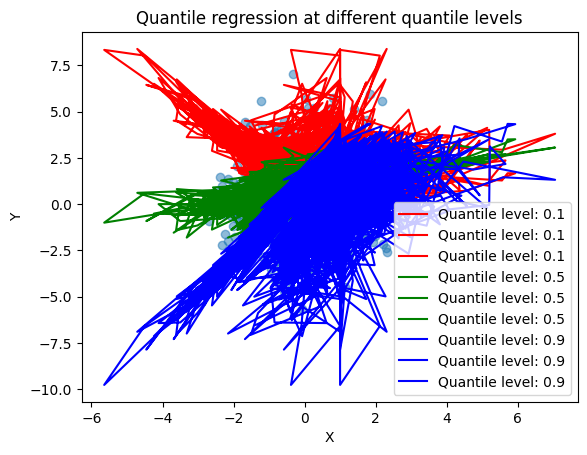

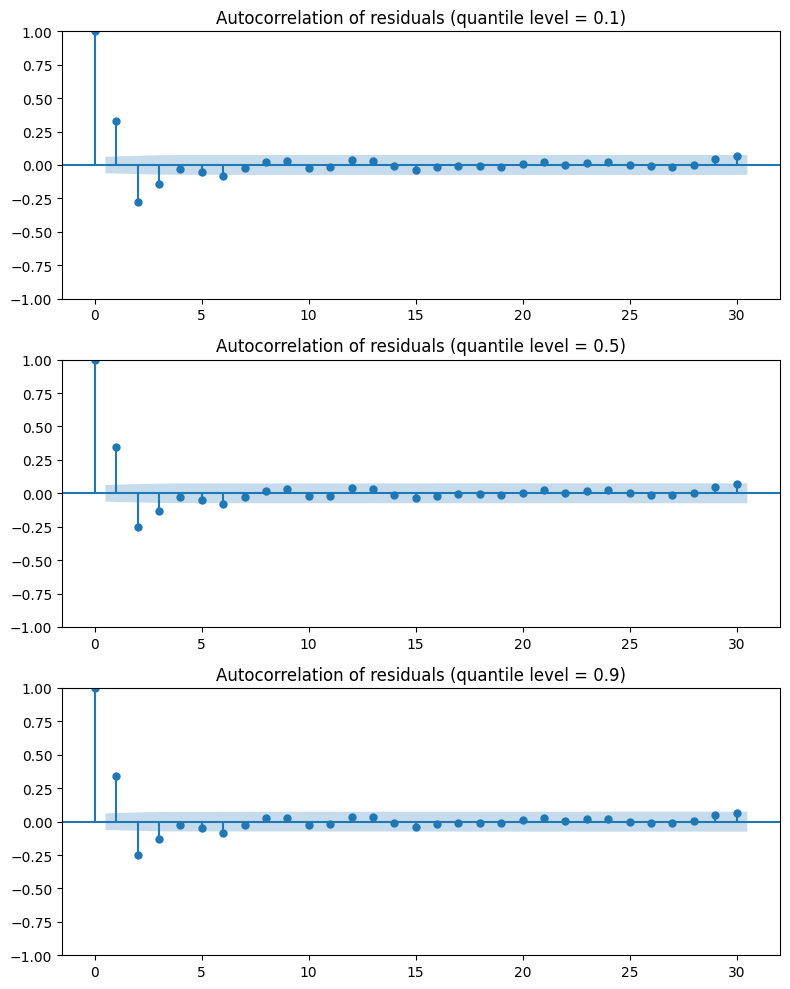

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.3033
 Model:                       QuantReg   Bandwidth:                      0.4751
 Method:                 Least Squares   Sparsity:                        7.881
 Date:                Tue, 02 May 2023   No. Observations:                 1000
 Time:                        12:14:47   Df Residuals:                      997
                                         Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -1.4716      0.078    -18.769      0.000      -1.625      -1.318
 x1             0.7311      0.043     16.925      0.000       0.646       0.816
 x2             0.3128      0.077      4.083      0.000       0.162   

In [89]:
fit_quantile(df)